# EXPECTS:
 `metadata.p` from Process Incoming data about all user sessions.
 `video_consolidated.p` from Processing Incoming data script in the user folder of interest, which is simply the pared down raw openface and eyeratio data that has had an approximate timestamp added based on what we believe from the GoPro.
 `sessions_blink.p` from Processing Incoming data script in the user folder of interest, which is just a list of DFs of glasses blink data, timestamped roughly using the serverTimestamp as a starting point and the uC tick as the main clock source.
 
# OUTPUTS:
 - the goal of this script is to output `best_offset.p` to the user session folder, which is the offset to add to the glasses data to align it to the video.
 
 - it is also to output `video_blink_sessions.p` -- a df of the video data that has been chopped into snippets in which the classifier believes it has succeeded continuously, along with session info and timestamps for each blink within the video.  We typically open this and save it as `vid_meta_data`.

 - it will also output `glasses_all_blink_timestamps_uncorrected.p` to the user folder, which is a list of blink times from the glasses without the offset applied.  These are discovered with our default algorithm set at thresh=0.06, blink_dur_ms=250, lpf_samples=50, dx_lpf_samples=25.
 
We will still need to APPLY a debounce to the video (could change threshold), and our BEST_OFFSET to any glasses data we work with, in the future.

In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os

pd.set_option('display.max_rows', 1000)
%matplotlib inline

### 1. Pick a session to work with!

In [5]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [2]:
SESSION = 'patrick_3'

let's print some basic summary statistics based on the metadata for this session:

In [7]:
s_meta = metadata[SESSION]

try:
    print(SESSION, 'on', s_meta['date'])
    print('-'*10)
    print(s_meta['glasses_sessions_total_duration_string'], 'hr of glassess data starting at', \
          s_meta['glasses_session_times'][0][0])
    print('%02d:%02d hr of    video data starting at ' % (s_meta['vid_duration_sec'] / 60 // 60, 
           s_meta['vid_duration_sec'] / 60 % 60 )  + s_meta['vid_start'])
    print('-'*10)
    print('glasses sessions:')
    for i in range(len(s_meta['glasses_session_times'])):
        print('session ' + str(i) + ':',s_meta['glasses_session_times'][i][0],'to',\
              s_meta['glasses_session_times'][i][1],'\tduration:%8.2f min' % s_meta['glasses_session_durations_min'][i])
except:
    print('failed to load video analysis file.')

patrick_3 on 04/28
----------
04:25 hr of glassess data starting at 04/28/21 01:10:27PM EDT
04:26 hr of    video data starting at 04/28/21 01:10:00PM EDT
----------
glasses sessions:
session 0: 04/28/21 01:10:27PM EDT to 04/28/21 05:35:58PM EDT 	duration:  265.52 min


### Load the Data
...and let's load in the data, and plot what we have just to take a look, by session

In [8]:
#load video data (eyeratio and openface features), 60 Hz (16 ms between samples)
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)

#load glasses blink data, 1kHz (1 ms between samples)
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))

# give some stupid FutureWarning error thanks to pandas and numpy not being in sync.
# https://stackoverflow.com/questions/48818335/why-pandas-read-csv-issues-this-warning-elementwise-comparison-failed

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
df_vid['success'].value_counts()

1    809518
0    148290
Name: success, dtype: int64

In [12]:
blink_sess[0].head()

,timestamp_ms,value
0,1619629828025,253
1,1619629828026,253
2,1619629828027,253
3,1619629828028,124
4,1619629828029,116


In [14]:
def string_to_timestamp_ms(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M:%S%p %Z').timestamp()*1000

def timestamp_ms_to_string(timestamp):
    local_tz = datetime.now().astimezone().tzinfo
    return datetime.fromtimestamp(timestamp/1000, tz=local_tz).strftime('%m/%d/%y %I:%M:%S%p %Z')

In [15]:
#not going to xcorr, just align with pulses later.  We'll just copy the timestamp_ms to est_timestamp_ms
new_df_vid = df_vid.copy()
new_df_vid['timestamp_ms'] = df_vid['est_timestamp_ms']

## Divide Openface Classifier Results into Sessions and Extract Blinks from the Glasses
It turns out our face extraction from open face doesn't actually work that well, and is pretty spotty.

To better assess how well we're doing with blinks, we need to chop the video data into usable sessions as well-- we'll pull sections where there are contiguous chunks of 'successful' tracking on the faces (with a minimum useful chunk of 200ms by default, and where we tolerate up to 2 consecutive dropped frames that we can interpolate).

We'll use these sections for all future analysis.


In [97]:
# Chop the video into useful sections based on success metric
def print_summary(df_vid, thresh=0.3):
    old_len = len(df_vid)
    df_vids = len(df_vid[df_vid['success'] == 1])
    print('Have',df_vids, 'frames considered successful, (%2.2f%%)' % (100.*df_vids/old_len))    
    df_vidc = len(df_vid[df_vid['confidence'] >= thresh])
    print('Have',df_vidc, 'frames above thresh of',thresh,'(%2.2f%%)' % (100.*df_vidc/old_len))
    
    return old_len, df_vids

def get_sessions_by_success(df_vid_in, min_sess_sec=0.2, tolerate_n_dropped_frames=2):
    sessions = []
    min_sess_len = min_sess_sec * 60 #samples in min_sess_sec is FPS*sec
    prev_tick = 0
    curr_sess = pd.DataFrame()
    
    old_len = len(df_vid_in)
    df_vid = df_vid_in.copy()
    df_vid = df_vid[df_vid['success'] == 1]
    print('Have',len(df_vid), 'frames considered successful, (%2.2f%%)' % (100.*len(df_vid)/old_len))
    
    #iterate over dataframe only where rows have success == 1
    for i, row in df_vid.iterrows():
        #when we skip a row because tracking failed, append current session
        #if it's long enough and start a new session over
        if row['tick_ms'] > (prev_tick + 24.5 + tolerate_n_dropped_frames*100/6.):
            if len(curr_sess) > min_sess_len:
                sessions.append(curr_sess)
            del curr_sess
            curr_sess = pd.DataFrame()
        
        curr_sess = curr_sess.append(row)
        prev_tick = row['tick_ms']        
        
    if len(curr_sess) > min_sess_len: sessions.append(curr_sess)
    
    return sessions


In [98]:
MIN_SEC_SESSION = 0.2
DROP_FRAMES = 2

print_summary(new_df_vid)
print('-'*20)
print('USING SUCCESSFUL BY OPENFACE STANDARD')
print('-'*20)
vid_sess = get_sessions_by_success(new_df_vid, 
                                   min_sess_sec=MIN_SEC_SESSION, 
                                   tolerate_n_dropped_frames=DROP_FRAMES)

print('found',len(vid_sess),'sessions.')

Have 809518 frames considered successful, (84.52%)
Have 814906 frames above thresh of 0.3 (85.08%)
--------------------
USING SUCCESSFUL BY OPENFACE STANDARD
--------------------
Have 809518 frames considered successful, (84.52%)
found 489 sessions.


#### Save the data

Given our time aligned video data and our chunks of reasonable tracking, we can save some metadata about what chunks we have and how many blinks we detect in each chunk.  This is what we'll use for ground truth.

In [100]:
def count_rising_edges(sess, column):
    #assuming a 1/0 signal, counts transitions to 1.  Starting at 1
    #counts as a transition.
    prev_row, count = 0, 0
    for i,row in sess.iterrows():
        if row[column] == 1 and prev_row == 0: count += 1
        prev_row = row[column]    
    return count

def count_rising_edges_list(values):
    #assuming a 1/0 signal, counts transitions to 1.  Starting at 1
    #counts as a transition.
    prev_row, count = 0, 0
    for v in values:
        if v == 1 and prev_row == 0: count += 1
        prev_row = v    
    return count

def rising_edge_times(sess, column, timecolumn):
    #assuming a 1/0 signal, returns transition times. Starting at 1
    #counts as a transition.
    prev_row, transitions = 0, []
    for i,row in sess.iterrows():
        if row[column] == 1 and prev_row == 0: 
            transitions.append(row[timecolumn])
        prev_row = row[column]    
    return transitions

In [101]:
total, successful = print_summary(df_vid, thresh=0.3)

vid_meta_data = {}
vid_meta_data['total_frames'] = total
vid_meta_data['successful_frames'] = successful
vid_meta_data['percent_successful'] = 100.*successful/total
vid_meta_data['total_duration_sec'] = total/60.
vid_meta_data['session_min_sec'] = MIN_SEC_SESSION
vid_meta_data['session_drop_frames'] = DROP_FRAMES
vid_meta_data['num_sessions'] = len(vid_sess)
vid_meta_data['session_times'] = [[s['timestamp_ms'].iloc[0], s['timestamp_ms'].iloc[-1]] for s in vid_sess]
vid_meta_data['duration_sessions_sec'] = [(s['timestamp_ms'].iloc[-1] - s['timestamp_ms'].iloc[0])/1000. for s in vid_sess]
vid_meta_data['session_total_sec'] = sum(vid_meta_data['duration_sessions_sec'])
vid_meta_data['blinks_per_session'] = [count_rising_edges(s, 'AU45_c') for s in vid_sess]
vid_meta_data['blink_timestamps_per_session'] = [rising_edge_times(s, 'AU45_c', 'timestamp_ms') for s in vid_sess]
vid_meta_data['total_blinks'] = sum(vid_meta_data['blinks_per_session'])
vid_meta_data['blinks_per_sec'] = vid_meta_data['total_blinks'] / vid_meta_data['session_total_sec']

print('Measured', vid_meta_data['total_blinks'], 'blinks.  That gives %.2f blinks/min' % (60.*vid_meta_data['blinks_per_sec']))

pickle.dump(vid_meta_data, open( './cleaned_data/' + SESSION + '/video_blink_sessions.p', "wb" ))

Have 809518 frames considered successful, (84.52%)
Have 814906 frames above thresh of 0.3 (85.08%)
Measured 5981 blinks.  That gives 26.59 blinks/min


So now we have the blinks arranged in blink sessions with start/end times that we 'trust', timestamps for each blink within those sections, and 
counts for number of blinks in each session, and duration of each session.  we can use vid_meta_data from now on.

We could need to debounce the extracted video data.  The timing also is not aligned automatically.

For glasses blink data, we have blink_sess which is not processed.

## Let's pull out all glasses blinks based on our baseline algorithm and store them as well

In [33]:
def grab_blinks(blink_sess, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['value'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp_ms':blink_sess['timestamp_ms'], 'dx':smooth_dx})
    
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    plt.plot(df_results['timestamp_ms'], df_results['dx'])
    plt.plot(df_results['timestamp_ms'], decision)
    plt.show()
    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms)  # happen to sample at 1kHz so 1 sample == 1 ms
    samples_blink_debounce = int(samples_per_blink/2)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp_ms'] = df_results['timestamp_ms'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            if reverse:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
            else:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
            
            blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
            blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
            blinkrow['duration_ms'] = max_open['timestamp_ms'].iloc[-1] - max_close['timestamp_ms'].iloc[0] #duration
            
            df_blinks = df_blinks.append(blinkrow, ignore_index=True)
            i += samples_blink_debounce #move ahead debounce samples before checking for blinks again
        else: i += 1
            
    return df_blinks

def get_all_blink_sessions(blink_sessions, thresh=0.06, blink_dur_ms=250, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    
    df_result = pd.DataFrame()
    for sess in blink_sessions:
        df_blinks = grab_blinks(sess,
                                thresh=thresh, 
                                blink_dur_ms=blink_dur_ms, 
                                lpf_samples=lpf_samples, 
                                dx_lpf_samples=dx_lpf_samples, 
                                reverse=reverse)
        df_result = df_result.append(df_blinks, ignore_index=True)
        
    return df_result

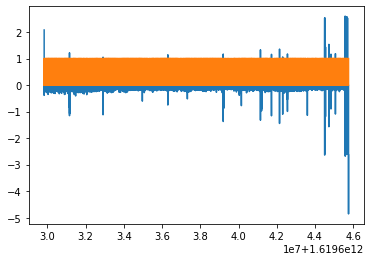

In [34]:
df_all_glasses_blinks = get_all_blink_sessions(blink_sess)
pickle.dump(df_all_glasses_blinks, open( './cleaned_data/' + SESSION + '/glasses_all_blink_timestamps_uncorrected.p', "wb" ))

In [38]:
#STREAM A SECTION OF VIDEO WITH A DF OVERLAY OF BLINK TIMES

#show video with overlay of a df with timestamps and an offset so we can manually check blink alignment of both the video DF and our video analysis DF
#above we were aligning the video to the glasses; here we'll align our glasses to the video

#lets just do everything in minutes like we were doing in the above
def stream_with_blink_data_overlay(video_filename, blinktime_list_ms, video_start_timestamp_ms, start_time_min, end_time_min, ms_offset=0, fps=59.94, plot_blinksig=False):

    start_frame = int(start_time_min*60*fps)
    end_frame = int(end_time_min*60*fps)
    
    print(start_frame)
    print(end_frame)
    #blink times to frame list:
    stream_starttime_sec = video_start_timestamp_ms/1000. + start_frame/fps
    blink_duration_sec = 0.2 # how long to show it on screen; make sure if it's a new blink we put a 0 in between
    frame_duration_sec = 1/fps #time between frames in sec
    
    #make array of proper length full of zeros
    blink_sig = np.zeros(end_frame-start_frame)
    
    #whenever we have a blink, put ones in there for blink_dur frames.  Make sure the sample before that blink is zero
    for btime in blinktime_list_ms:
        btime_sec_stream = ((btime+ms_offset)/1000.)-stream_starttime_sec
        if -blink_duration_sec < btime_sec_stream < (end_time_min-start_time_min)*60:
            bframe = int(btime_sec_stream*fps)
            print((btime/1000), bframe)
            
            if bframe < 1:
                blink_sig[0:bframe+int(blink_duration_sec*fps)] = 1
            elif bframe+int(blink_duration_sec*fps) > len(blink_sig):
                blink_sig[bframe-1] = 0  
                blink_sig[bframe:-1] = 1
            else:
                blink_sig[bframe-1] = 0  
                blink_sig[bframe:bframe+int(blink_duration_sec*fps)] = 1
                
    if plot_blinksig:
        fig, ax = plt.subplots(figsize=(20,4))
        plt.plot(blink_sig)
        plt.title('blink signal') 
        plt.show()
     
    WINDOW_NAME = 'blink_window'
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()

    vs = cv2.VideoCapture(video_filename)
    vs.set(cv2.CAP_PROP_POS_FRAMES, start_frame-1)
    time.sleep(1.0)
    

    prev_frame, blink_count = 0, 0
    for fno in range(0, end_frame-start_frame):
        _, frame = vs.read()  
        #frame = imutils.resize(frame, width=480)
    
        if not fno:
            os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Python" to true' ''') 
    
        if blink_sig[fno] and not prev_frame:
            blink_count += 1
            
        
        cv2.putText(frame, "COUNT: %d"%(blink_count), (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
       
        if blink_sig[fno]:
            cv2.putText(frame, "BLINKING NOW!!!!!!", (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # show the frame
        cv2.imshow(WINDOW_NAME, frame)
        key = cv2.waitKey(1) & 0xFF

        prev_frame = blink_sig[fno]
        
        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

    # do a bit of cleanup
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    os.system('''/usr/bin/osascript -e 'tell app "Finder" to set frontmost of process "Chrome" to true' ''') 
    
    
def try_offsets_and_overlay(video_filename, blinktime_list_ms, video_start_timestamp_ms, start_time_min, end_time_min):
    ms_offset = int(input('enter a MS offset:'))
    first = True
    while True:
        stream_with_blink_data_overlay(video_filename, 
                               blinktime_list_ms, 
                               video_start_timestamp_ms, 
                               start_time_min, 
                               end_time_min,
                               ms_offset,
                               plot_blinksig=first)
        first = False
        
        cont = input('enter new MS offset or q to exit')
        
        if str(cont) == 'q':
            print('best offset = ', ms_offset)
            return ms_offset
        
        ms_offset = int(cont)

session # 162 of 489
duration: 684.116 sec
blinks: 325


enter a MS offset: 0


253769
257366
1619634034.63 54
1619634037.483 225
1619634039.969 374
1619634047.276 812
1619634049.395 939
1619634053.783 1202
1619634056.519 1366
1619634058.204 1467
1619634064.594 1850
1619634065.661 1914
1619634067.48 2023
1619634069.632 2152
1619634072.101 2300
1619634072.835 2344
1619634075.304 2492
1619634075.738 2518
1619634076.038 2536
1619634076.289 2551
1619634077.223 2607
1619634079.909 2768
1619634081.344 2854
1619634084.28 3030
1619634085.882 3126
1619634086.549 3166
1619634087.25 3208
1619634089.919 3368
1619634090.72 3416
1619634091.687 3474
1619634092.271 3509
1619634092.438 3519


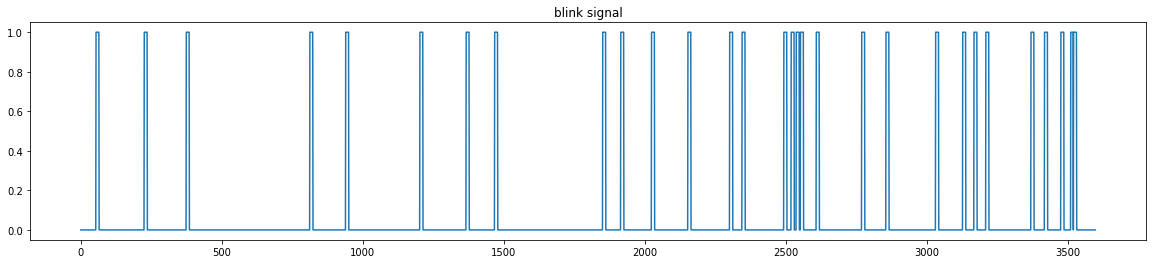

enter new MS offset or q to exit q


best offset =  0
session # 420 of 489
duration: 534.467 sec
blinks: 278


enter a MS offset: q


ValueError: invalid literal for int() with base 10: 'q'

In [30]:
#pick a vid_session and overlay df, see if it looks right!

vid_start_timestamp = string_to_timestamp_ms(s_meta['vid_start'])

#pick the longest 4 to watch
NUM_SESS_TO_WATCH = 4

indices = (-np.array(vid_meta_data['duration_sessions_sec'])).argsort()[:NUM_SESS_TO_WATCH]
for SESS_NUM in indices:

    print('session #', SESS_NUM, 'of', vid_meta_data['num_sessions'])
    print('duration:', vid_meta_data['duration_sessions_sec'][SESS_NUM],'sec')
    print('blinks:', vid_meta_data['blinks_per_session'][SESS_NUM])

    optimal_offset = try_offsets_and_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_crop_1.mp4',  #/openface/video_adobe.mp4
                               vid_meta_data['blink_timestamps_per_session'][SESS_NUM],                   #list of blink times in clip
                               vid_start_timestamp,                                                       #start timestamp of video
                               (vid_meta_data['session_times'][SESS_NUM][0]-vid_start_timestamp)/60000.0, #start timestamp of clip we're watching in min from start
                               (vid_meta_data['session_times'][SESS_NUM][0]-vid_start_timestamp + 60*1000)/60000.0) #end timestamp of clip we're watching in min from start
                               #(vid_meta_data['session_times'][SESS_NUM][1]-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start

session # 162 of 489
duration: 684.116 sec
blinks: 325


enter a MS offset: -4330


253769
257366
1619634038.114 4
1619634040.6 153
1619634040.858 168
1619634042.076 241
1619634044.304 375
1619634044.648 395
1619634046.761 522
1619634050.514 747
1619634050.961 774
1619634051.576 810
1619634052.198 848
1619634053.696 937
1619634054.902 1010
1619634056.526 1107
1619634058.083 1200
1619634060.833 1365
1619634062.497 1465
1619634069.952 1912
1619634071.781 2022
1619634073.924 2150
1619634076.411 2299
1619634077.126 2342
1619634079.621 2491
1619634081.527 2606
1619634084.202 2766
1619634085.652 2853
1619634088.579 3028
1619634090.185 3125
1619634090.861 3165
1619634091.563 3207
1619634092.222 3247
1619634094.226 3367
1619634095.02 3414
1619634095.989 3473


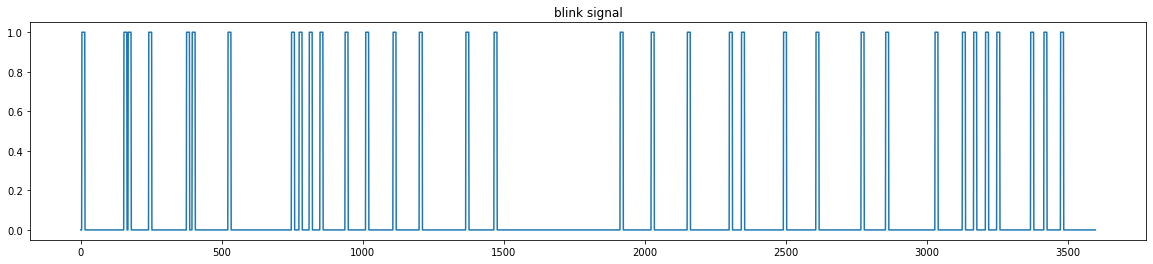

KeyboardInterrupt: Interrupted by user

In [71]:
#Let's try the same thing with the glasses data

#pick the longest 4 to watch
NUM_SESS_TO_WATCH = 4

indices = (-np.array(vid_meta_data['duration_sessions_sec'])).argsort()[:NUM_SESS_TO_WATCH]
for SESS_NUM in indices:

    print('session #', SESS_NUM, 'of', vid_meta_data['num_sessions'])
    print('duration:', vid_meta_data['duration_sessions_sec'][SESS_NUM],'sec')
    print('blinks:', vid_meta_data['blinks_per_session'][SESS_NUM])

    optimal_offset = try_offsets_and_overlay('/Volumes/ExtDrive_(ResEnv)/data_cap_val_2/' + SESSION + '/video_crop_1.mp4',  #/openface/video_adobe.mp4
                               df_all_glasses_blinks['timestamp_ms'].values,                              #list of blink times in clip
                               vid_start_timestamp,                                                       #start timestamp of video
                               (vid_meta_data['session_times'][SESS_NUM][0]-vid_start_timestamp)/60000.0, #start timestamp of clip we're watching in min from start
                               (vid_meta_data['session_times'][SESS_NUM][0]-vid_start_timestamp + 60*1000)/60000.0) #end timestamp of clip we're watching in min from start
                               #(vid_meta_data['session_times'][SESS_NUM][1]-vid_start_timestamp)/60000.0) #end timestamp of clip we're watching in min from start

### there is a clear alignment between the two above; we need to move the glasses data earlier in time by about 300 frames, or 200/59.94 =  -4 sec (4250ms)

Let's bound our search between -4 and -5 ms offset applied to the glasses df

In [58]:
#now lets align and retest
flatten = lambda t: [item for sublist in t for item in sublist]

def debounce_data(list_of_times, debounce_dur_ms=150):
    
    indices_to_remove = []
    for i in range(1, len(list_of_times)):
        if list_of_times[i-1] >= list_of_times[i] - debounce_dur_ms:
            indices_to_remove.append(i)

    for index in sorted(indices_to_remove, reverse=True):
        del list_of_times[index]
        
    return list_of_times

def chop_times(list_of_times, min_time, max_time):
    return [c for c in list_of_times if min_time < c < max_time]


#we want to sweep the glasses data over the video data; we want to only consider a smaller section of the glasses data than video data,
#and only use one section where we know the video data is complete and doesn't have holes.  These areas of holes or more/less blinks 
#around the edges of our xcorr can mess up the calculation

def get_optimal_offset(g_times, v_times, offset_lower_ms, offset_higher_ms, step_ms, thresh_ms): 

    #seems to be fine, need to discount all video blinks not in glasses range, but in from both sides by 2*s_meta['start_error_sec']*1000
    #df_blink only has a few blinks in it-- short session?  Need all blinks

    
    print('pruning g_times for alignment',len(g_times))
    g_times = chop_times(g_times, v_times[0]+offset_lower_ms, v_times[-1]-offset_higher_ms)
    
    errors = []
    #move through all offsets we can think about, brute force
    best_offset, min_error = None, None 
    for offset in range(offset_lower_ms, offset_higher_ms, step_ms):
        offset_error = 0
        curr_index = 0

        for gtime in g_times:
            while v_times[curr_index] <= (gtime+offset):
                if curr_index==(len(v_times)-1): break
                curr_index+=1
            
            if curr_index == 0:
                curr_err = abs((gtime+offset)-v_times[0])
            elif curr_index == len(v_times)-1:
                curr_err = min(abs((gtime+offset)-v_times[curr_index-1]), abs(v_times[curr_index]-(gtime+offset)))   
            else:
                curr_err = min((gtime+offset)-v_times[curr_index-1], v_times[curr_index]-(gtime+offset))

            if curr_err < thresh_ms: curr_err = 0
            offset_error += curr_err
            #print('curr, accum err:',curr_err, offset_error)
        
        errors.append(offset_error)
        
        if best_offset is None:
            best_offset = [offset]
            min_error = offset_error
        elif offset_error < min_error:
            #print('new min!')
            best_offset = [offset]
            min_error = offset_error
            #print(min_error, best_offset)
        elif offset_error == min_error:
            print('shared min!')
            best_offset.append(offset)
            print(min_error, best_offset)
        
    fig, ax = plt.subplots(figsize=(20,4))
    plt.plot(range(offset_lower_ms, offset_higher_ms, step_ms), errors)
    plt.title('xcorr of offsets') 
    plt.show()    
    
    return best_offset

pruning g_times for alignment 7607


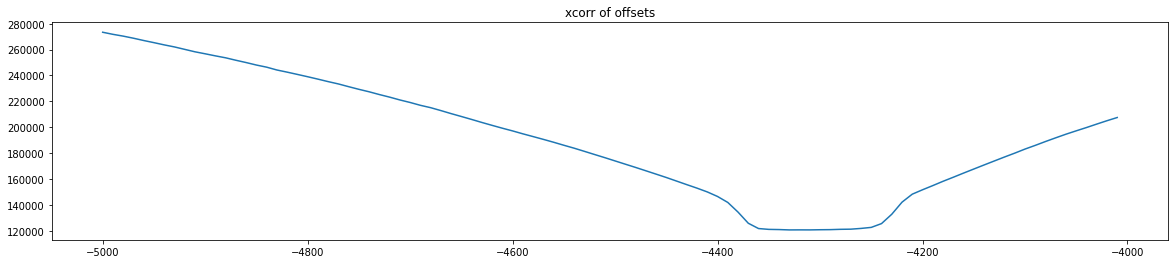

optimal offset with thresh of 75 ms:
[-4330]


In [59]:
MIN_ALIGN_ERROR = -5000
MAX_ALIGN_ERROR = -4000

#get blink times of longest video section we trust
indices = (-np.array(vid_meta_data['duration_sessions_sec'])).argsort()[0]
v_times = vid_meta_data['blink_timestamps_per_session'][indices]
v_times = debounce_data(v_times)

#just pull g_times into a list
g_times = df_all_glasses_blinks['timestamp_ms'].values
best_offset = get_optimal_offset(g_times, v_times, MIN_ALIGN_ERROR, MAX_ALIGN_ERROR, 10, 75)
print('optimal offset with thresh of 75 ms:')
print(best_offset)

In [ ]:
pickle.dump(best_offset[0], open( './cleaned_data/' + SESSION + '/best_offset.p', "wb" ))